### Tehran housing price data analysis
I will present an analysis about renting a house price in this notebook. Housing data is generated from Tehran Divar website and the dataset contains data about renting house in Theran at the end of 1402. I use different types of ML Methods for evaluating model and comparing the results of those types.

In [251]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!pip install Unidecode
from unidecode import unidecode

!pip install arabic-reshaper
!pip install python-bidi
from bidi.algorithm import get_display
from arabic_reshaper import reshape

!pip install geopandas
import geopandas as gpd
import geopandas.tools
!pip install shapely
from shapely.geometry import Point

### Why Tehran housing price
There are some major reasons for me to do this research:

1.Population: Tehran is the capital and major city in Iran. It also hosts more than 9 million population in 2021, which makes it the second populated city in the middle east.

2.Housing transactions: More than 83,000 housing transactions are being made per year in Tehran.

3.Housing price: Housing price has rappidly grown during the last decade in Tehran.

4.Districts: Tehran consists of 22 districts and many neighbourhoods, so finding a good and cheap place to live seems difficault.

# 1. Data Preprocessing
In this section, I will load the dataset and do some preprocessing on it. I will also do some exploratory data analysis to understand the data better.

## 1.1 Combine All Datasets

In [292]:
# combine all data in path .\Divar_WebScrap\Data\Data_clean_*.csv

path = './Divar_WebScrap/Data'
files = os.listdir(path)
files = [f for f in files if f.startswith('Dataset_tehran')]
df = pd.concat([pd.read_csv(os.path.join(path, f)) for f in files], ignore_index=True)
#drop name, description, link
df_clean = df.copy()
df_clean = df_clean.drop(['name','rent','deposit','description','direction','link'], axis=1)
df_clean.shape

(25585, 15)

In [293]:
df_clean.head()

neighborhood  area  year  room  buildingFloors  unitFloor  elevator  \
0            دروس   280  1401     3               0          0         1   
1          افسریه    61  1399     2               4          3         1   
2            هروی   200  1402     3               5          5         1   
3      سعادت‌آباد    85  1395     2               5          3         1   
4  جنت‌آباد شمالی    73  1390     2               0          0         1   

   parking  warehouse  balcony  unitPerFloor  unitStatus  longitude  \
0        1          1        0             0           0   0.000000   
1        1          1        1             1           0  51.498425   
2        1          1        1             1           0  51.479416   
3        1          1        0             4           1   0.000000   
4        0          0        1             1           0   0.000000   

    latitude   total_value  
0   0.000000  2.006600e+09  
1  35.632595  4.000900e+08  
2  35.768784  4.600000e+09  
3   0.000000  1.450000e+09  
4   0.000000  2.004500e+08

### Reading Data
RawData stored in csv file has 25585 records containing 15 features. Features are:

1. **total_value**: is the overall value of the house. It is calculated based on deposit and monthly rent.
2. **neighborhood**: is filled based on the house position in Tehran.
3. **area**: is the area of house in squared meter.
4. **year**: is the year that the house is built.
5. **room**: is the number of rooms in the house.
6. **buldingFloors**: is the number of floors in the building.
7. **unitFloors**: is the number of floors in the unit.
8.  **elevator**: indicates that house has elevator (1 for has and 0 for dose not have).
9.  **parking**: indicates that house has parking lot (1 for has and 0 for dose not have).
10. **warehouse**: indicates that house has warehouse (1 for has and 0 for dose not have).
11. **balcony**: indicates that house has balcony (1 for has and 0 for dose not have).
12. **unitPerFloor**: is the number of units in each floor of the building.
13. **unitStatus**: indicates that the house is new or old (1 for new and 0 for old).
14. **longitude**: is the longitude of the house.
15. **latitude**: is the latitude of the house.

In [294]:
# remove duplicates
df_clean.drop_duplicates(subset =None, keep = 'first', inplace = True)

df_clean['neighborhood'] = df_clean['neighborhood'].astype(pd.StringDtype())

df_clean.shape

(17937, 15)

In [295]:
df_clean.head(5)

neighborhood  area  year  room  buildingFloors  unitFloor  elevator  \
0            دروس   280  1401     3               0          0         1   
1          افسریه    61  1399     2               4          3         1   
2            هروی   200  1402     3               5          5         1   
3      سعادت‌آباد    85  1395     2               5          3         1   
4  جنت‌آباد شمالی    73  1390     2               0          0         1   

   parking  warehouse  balcony  unitPerFloor  unitStatus  longitude  \
0        1          1        0             0           0   0.000000   
1        1          1        1             1           0  51.498425   
2        1          1        1             1           0  51.479416   
3        1          1        0             4           1   0.000000   
4        0          0        1             1           0   0.000000   

    latitude   total_value  
0   0.000000  2.006600e+09  
1  35.632595  4.000900e+08  
2  35.768784  4.600000e+09  
3   0.000000  1.450000e+09  
4   0.000000  2.004500e+08

In [296]:
# calculate all Nan values of each column
df_clean.isna().sum()

neighborhood      0
area              0
year              0
room              0
buildingFloors    0
unitFloor         0
elevator          0
parking           0
warehouse         0
balcony           0
unitPerFloor      0
unitStatus        0
longitude         0
latitude          0
total_value       0
dtype: int64

In [297]:
# drop rows with Nan values of neighborhood
df_clean.dropna(subset=['neighborhood'], inplace=True)
# calculate mean longitude and latitude of each neighborhood
df_neigh = df_clean.groupby('neighborhood').agg({'longitude': 'mean', 'latitude': 'mean'}).reset_index()
# fill rows with Nan values of longitude and latitude with the mean of the neighborhood
df_clean = df_clean.merge(df_neigh, on='neighborhood', suffixes=('', '_mean'))
df_clean['longitude'].fillna(df_clean['longitude_mean'], inplace=True)
df_clean['latitude'].fillna(df_clean['latitude_mean'], inplace=True)
df_clean.drop(columns=['longitude_mean', 'latitude_mean'], inplace=True)
# drop rows with Nan values of longitude and latitude
df_clean.dropna(subset=['longitude', 'latitude'], inplace=True)
df_clean.isna().sum()

neighborhood      0
area              0
year              0
room              0
buildingFloors    0
unitFloor         0
elevator          0
parking           0
warehouse         0
balcony           0
unitPerFloor      0
unitStatus        0
longitude         0
latitude          0
total_value       0
dtype: int64

### Data summarization
As you will see, the data set has 14 useful and clean features and 1 goal feature which is total_value. All columns of dataset has defined types so that we can work with them easily.

As I said before, total_value has been calculated based on deposit and rent, therefore I need to remove those 2 columns. At last dataset will have 6 features and 1 goal feature.

I grouped data by neighborhood feature and get a summary for the total_value field. You can see the maximum, minimm, median, count and variance of total_value in each neighborhood. You may also notice

In [298]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17937 entries, 0 to 17936
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   neighborhood    17937 non-null  string 
 1   area            17937 non-null  int64  
 2   year            17937 non-null  int64  
 3   room            17937 non-null  int64  
 4   buildingFloors  17937 non-null  int64  
 5   unitFloor       17937 non-null  int64  
 6   elevator        17937 non-null  int64  
 7   parking         17937 non-null  int64  
 8   warehouse       17937 non-null  int64  
 9   balcony         17937 non-null  int64  
 10  unitPerFloor    17937 non-null  int64  
 11  unitStatus      17937 non-null  int64  
 12  longitude       17937 non-null  float64
 13  latitude        17937 non-null  float64
 14  total_value     17937 non-null  float64
dtypes: float64(3), int64(11), string(1)
memory usage: 2.1 MB


## 1.2 Removing useless records (outliers)
Some houses have very unusual total_value or area. I consider them as outliers and remove them all and show them in graph below.

### Draw Scatter Plot & Box Plot
I draw a scatter plot and a box plot to show the outliers. As you can see, there are some houses with very high total_value and some with very high area. I consider them as outliers and remove them from the dataset.

In [300]:
def draw_scatter_plot(selected_df):
    fig , axes = plt.subplots(2,1,figsize = (18, 10))
    g1 = sns.scatterplot(x = [get_display(reshape(label)) for label in selected_df['neighborhood']]
                        , y = "total_value", data = selected_df, ax=axes[0])
    # g1.set(title=get_display(reshape('ارزش ملک در محله ها')))
    # g1.set(ylabel=get_display(reshape('ارزش ملک')))
    g1.set(title='Comparision the Value of Houses in Neighbourhoods');
    g1.set(ylabel='Value (in Tooman)');
    for ind, label in enumerate(g1.get_xticklabels()):
        if ind % 5 == 0:  # every 10th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)
    g1.set(xlabel=None)
    plt.setp(axes[0].get_xticklabels(), rotation=90)


    g2 = sns.scatterplot(x = [get_display(reshape(label)) for label in selected_df['neighborhood']]
                        , y = "area", data = selected_df, ax=axes[1])
    # g2.set(title=get_display(reshape('متراژ ملک در محله ها')))
    # g2.set(ylabel=get_display(reshape('متراژ ملک')))
    g2.set(title='Comparision the Area of Houses in Neighbourhoods');
    g2.set(ylabel='Area (in Meter)');
    for ind, label in enumerate(g2.get_xticklabels()):
        if ind % 5 == 0:  # every 10th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)
    g2.set(xlabel=None)
    plt.setp(axes[1].get_xticklabels(), rotation=90)

    plt.tight_layout()
    plt.show()

# Data distribution in top 15 neighbourhoods according to ads count
def draw_box_plot(selected_df):
    plt.figure(figsize= (18, 8))

    df_head_provinces = pd.DataFrame(selected_df['neighborhood'].value_counts(sort = True))
    df_top_15 = selected_df[selected_df['neighborhood'].isin(df_head_provinces.head(15).index)]

    sns.boxplot(x = [get_display(reshape(label)) for label in df_top_15['neighborhood']] 
                , y = "total_value", data = df_top_15)
    # plt.title(get_display(reshape('توزیع داده در 15 محله پر آگهی')),fontsize="15")
    plt.title('Data Distribution in Top 15 Neiboughrhoods (according to ads count)',fontsize="15")
    plt.xlabel('Neighbourhood');
    plt.ylabel('Value (in Tooman)');
    plt.xticks(rotation = "vertical")
    plt.show()

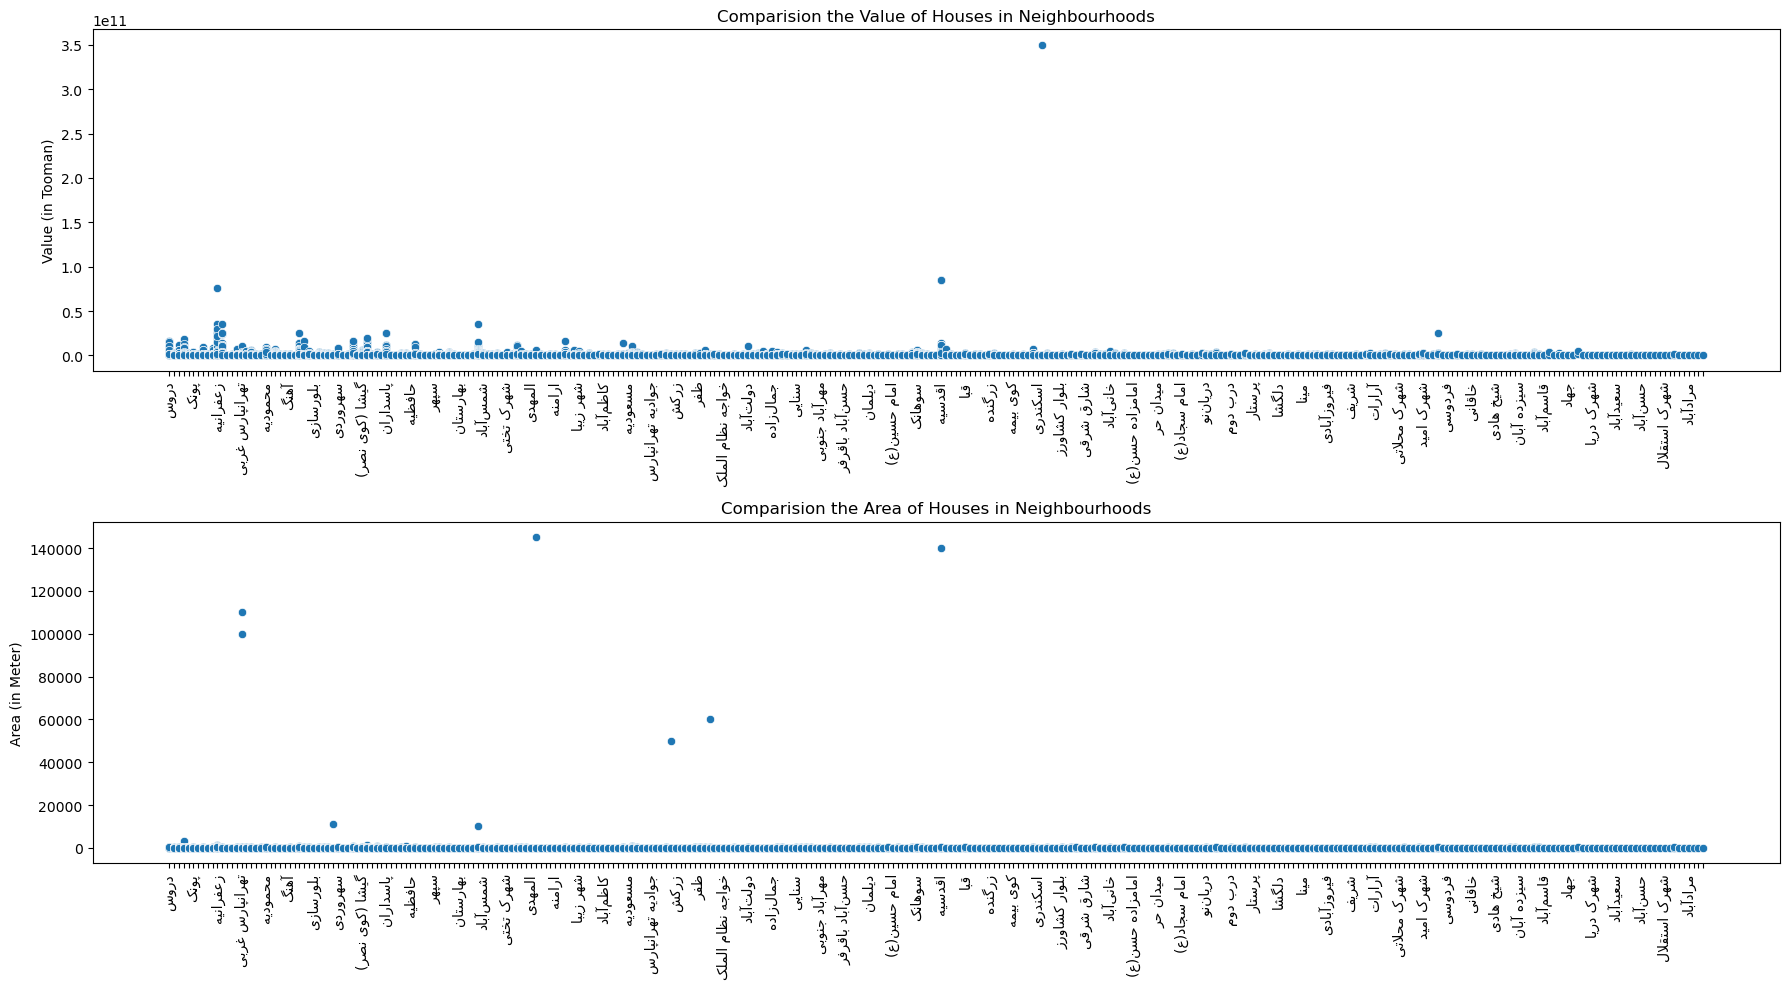

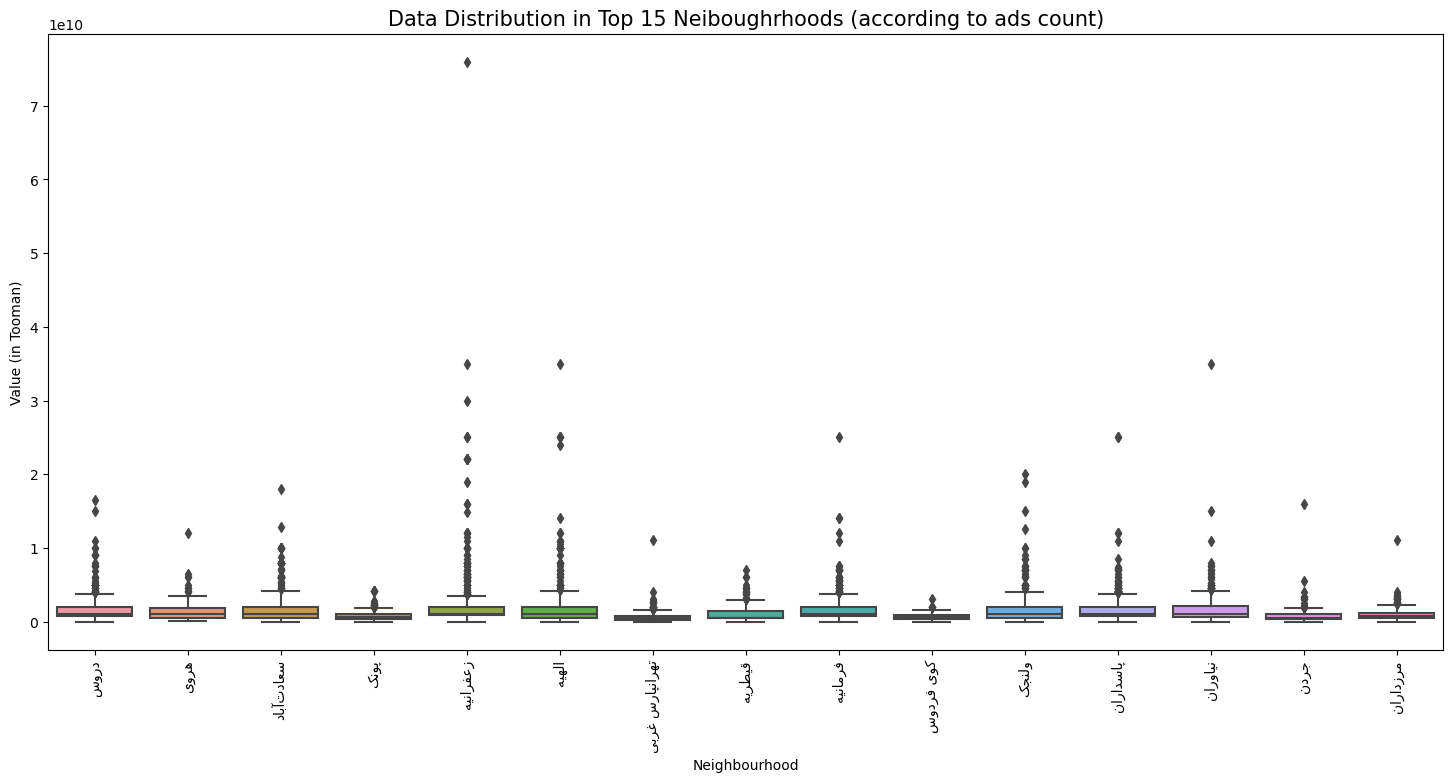

In [301]:
draw_scatter_plot(df_clean)
draw_box_plot(df_clean)

In [302]:
df_temp = df_clean[(df_clean['total_value'] > 10000000000) | (df_clean['area'] >= 500)]
df_temp.shape

(127, 15)

In [303]:
# Removing outliers
df_temp = df_clean[df_clean['total_value'] > 10000000000]
# print (df_temp)
print('Outliers count the field of total_value:',df_temp['neighborhood'].count())
df_normal = df_clean[df_clean['total_value'] < 10000000000]

df_temp = df_clean[df_clean['area']  >= 1000]
print('Outliers count the field of area:',df_temp['neighborhood'].count())
# print(df_temp)
df_normal = df_clean[df_clean['area'] < 1000]

print('Final valid data count:',df_clean['neighborhood'].count())

Outliers count the field of total_value: 88
Outliers count the field of area: 12
Final valid data count: 17937


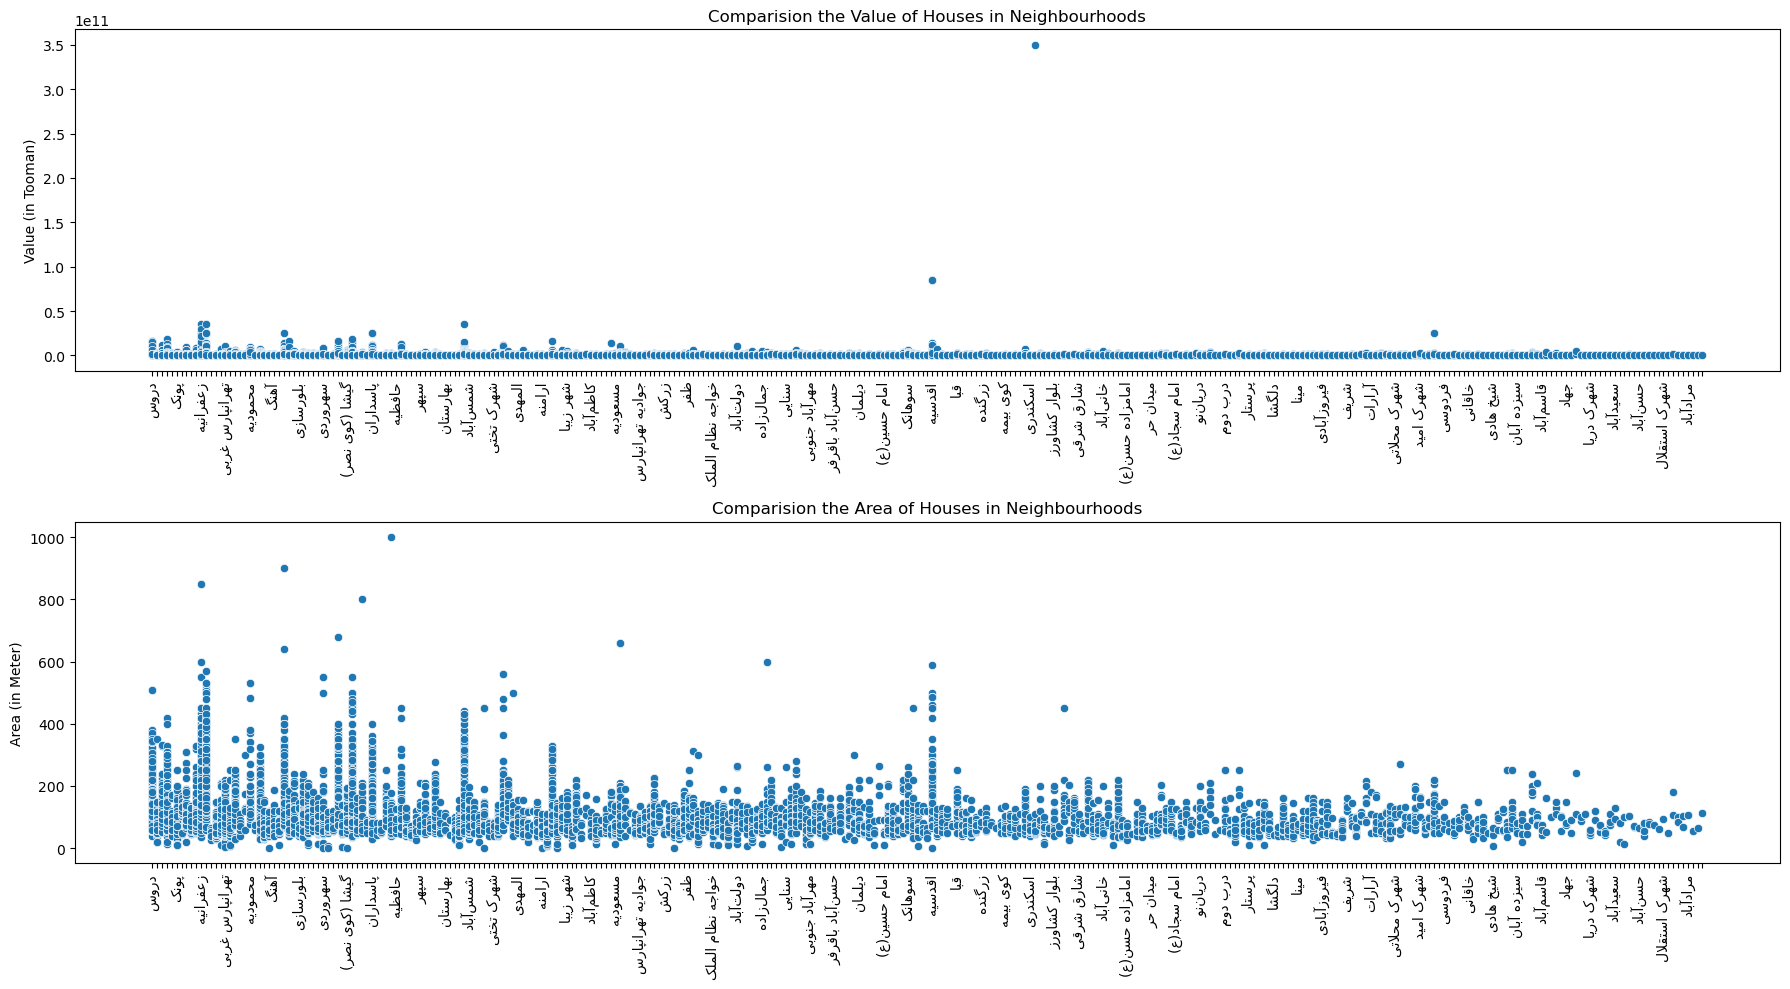

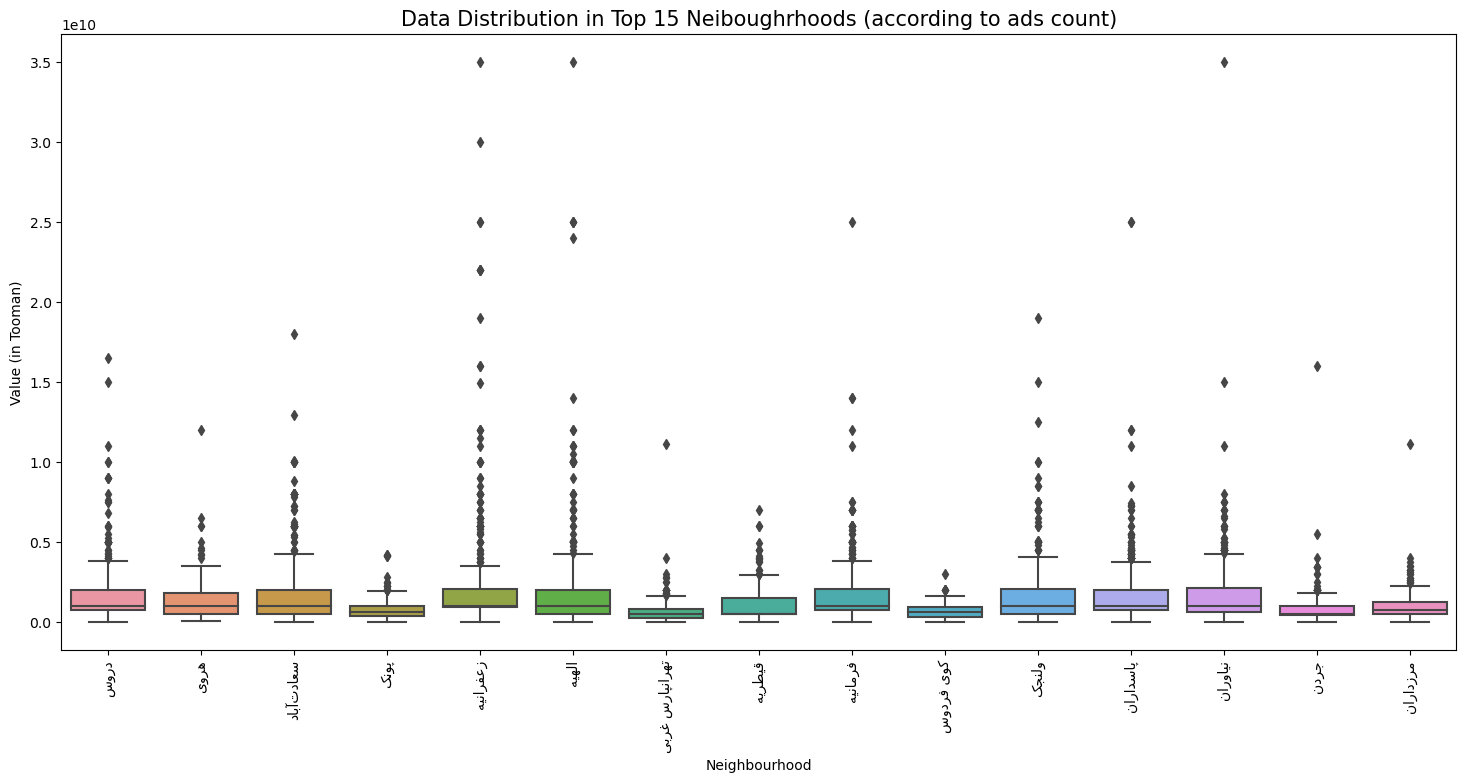

In [304]:
draw_scatter_plot(df_normal)
draw_box_plot(df_normal)

In [307]:
# remove outliers using quantile total_value
Q1 = df_normal['total_value'].quantile(0.25)
Q3 = df_normal['total_value'].quantile(0.75)
IQR = Q3 - Q1
df_normal = df_normal[(df_normal['total_value'] > (Q1 - 1.5 * IQR)) & (df_normal['total_value'] < (Q3 + 1.5 * IQR))]
df_normal.shape

(16342, 15)

In [308]:
# remove outliers using quantile area
Q1 = df_normal['area'].quantile(0.25)
Q3 = df_normal['area'].quantile(0.75)
IQR = Q3 - Q1
df_normal = df_normal[(df_normal['area'] > (Q1 - 1.5 * IQR)) & (df_normal['area'] < (Q3 + 1.5 * IQR))]
df_normal.shape

(15684, 15)

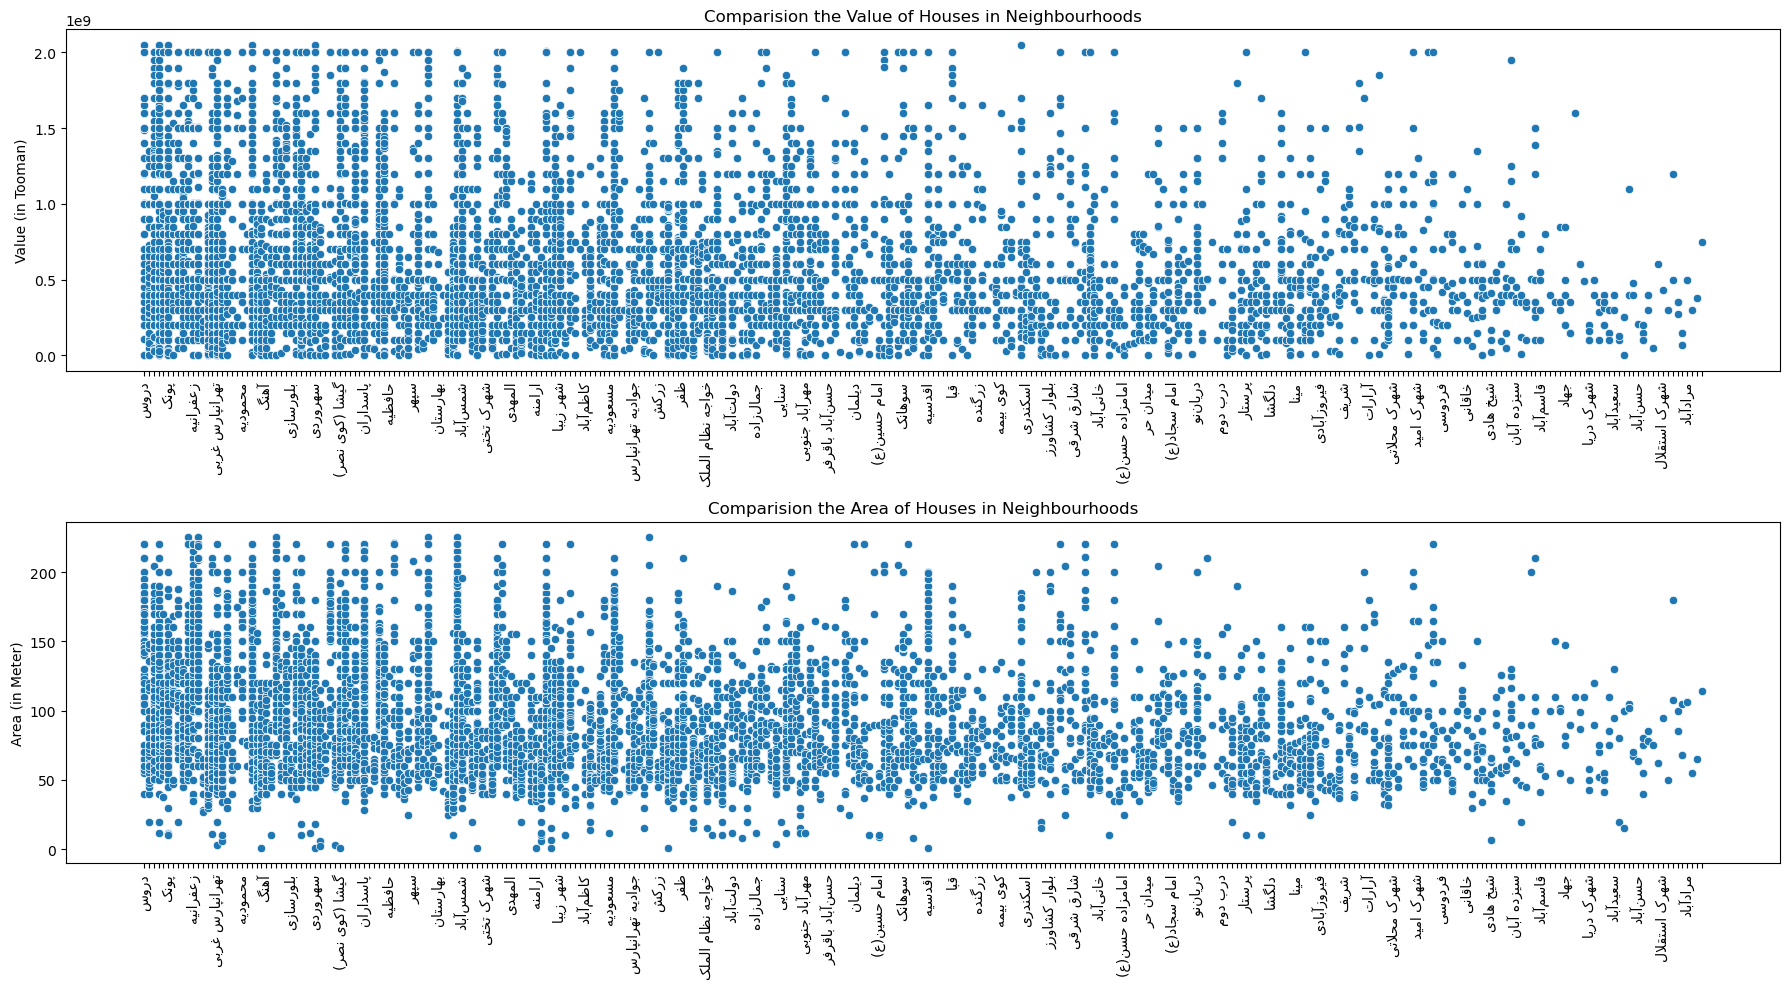

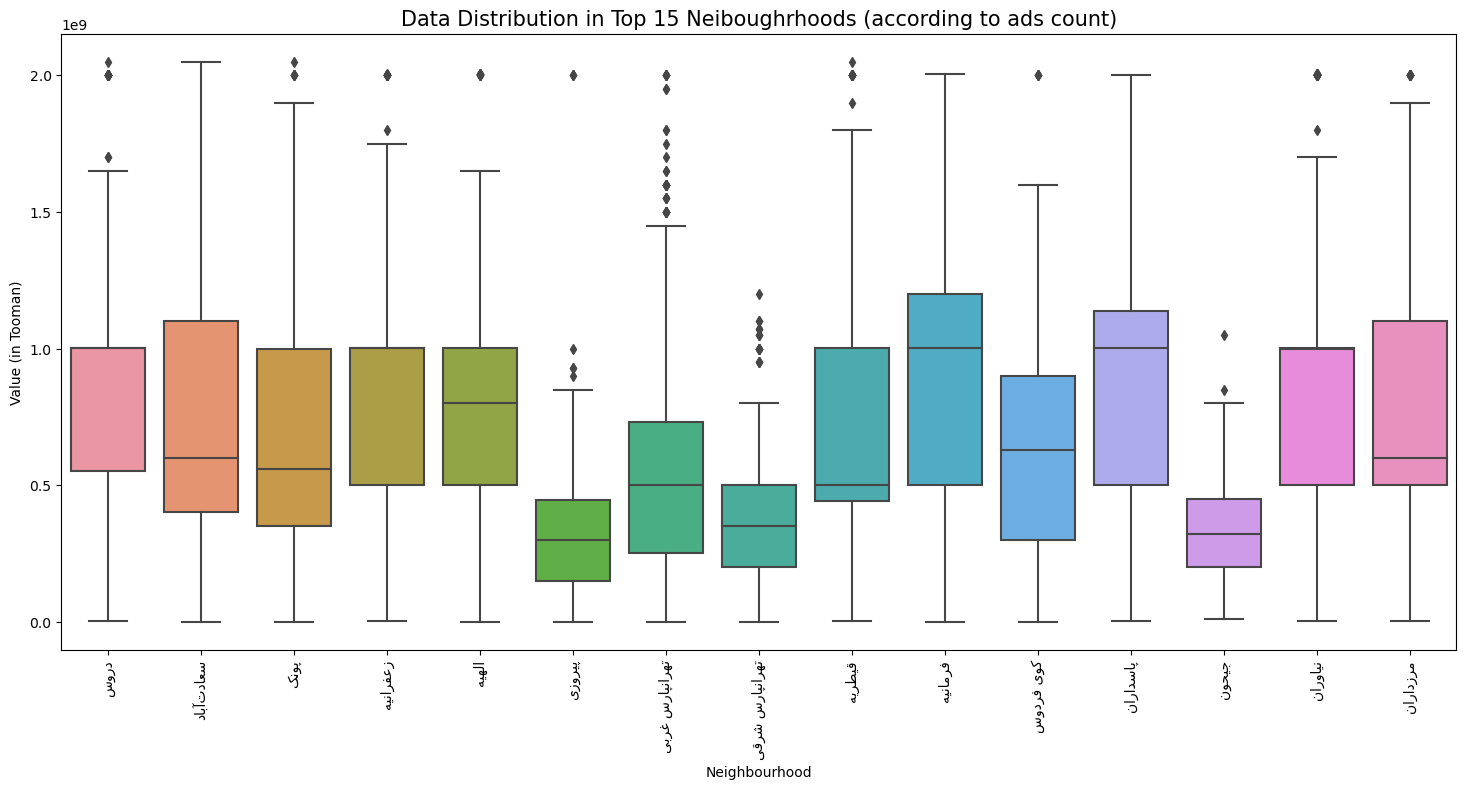

In [309]:
draw_scatter_plot(df_normal)
draw_box_plot(df_normal)

## 2. Data Analysis
In this section, I will do some exploratory data analysis to understand the data better.

### 2.1 Neighborhoods Analysis
I will show the number of houses in each neighborhood and the average total_value of houses in each neighborhood. I will also show the average area of houses in each neighborhood.

In [310]:
df_neigh_group = df_normal.groupby('neighborhood')[['total_value']].agg([np.min ,np.max, np.mean, np.var, 'count']).reset_index().sort_values(by=('total_value', 'count'), ascending=False)
df_neigh_group

neighborhood  total_value                                            \
                            amin          amax          mean           var   
143      سعادت‌آباد      30000.0  2.050000e+09  8.359854e+08  3.189599e+17   
290            پونک      39000.0  2.050000e+09  6.705126e+08  1.892975e+17   
236          قیطریه    3450000.0  2.050003e+09  7.389426e+08  2.520743e+17   
62   تهرانپارس غربی      45000.0  2.003000e+09  5.994203e+08  2.065041e+17   
246        مرزداران    1003000.0  2.001500e+09  8.212670e+08  2.532162e+17   
..              ...          ...           ...           ...           ...   
45           ایوانک   10030000.0  1.003000e+07  1.003000e+07           NaN   
46            بازار  300045000.0  3.000450e+08  3.000450e+08           NaN   
47         باغ آذری  400000000.0  4.000000e+08  4.000000e+08           NaN   
287          پامنار   20090000.0  2.009000e+07  2.009000e+07           NaN   
173    شهرک استقلال  430000000.0  4.300000e+08  4.300000e+08           NaN   

           
    count  
143   699  
290   580  
236   415  
62    414  
246   358  
..    ...  
45      1  
46      1  
47      1  
287     1  
173     1  

[319 rows x 6 columns]

### Top 15 neighbourhoods according to ads count
I also calculated the number of ads in each neighborhood and sorted them in descending order. You can see the top 15 neighborhoods in Tehran.

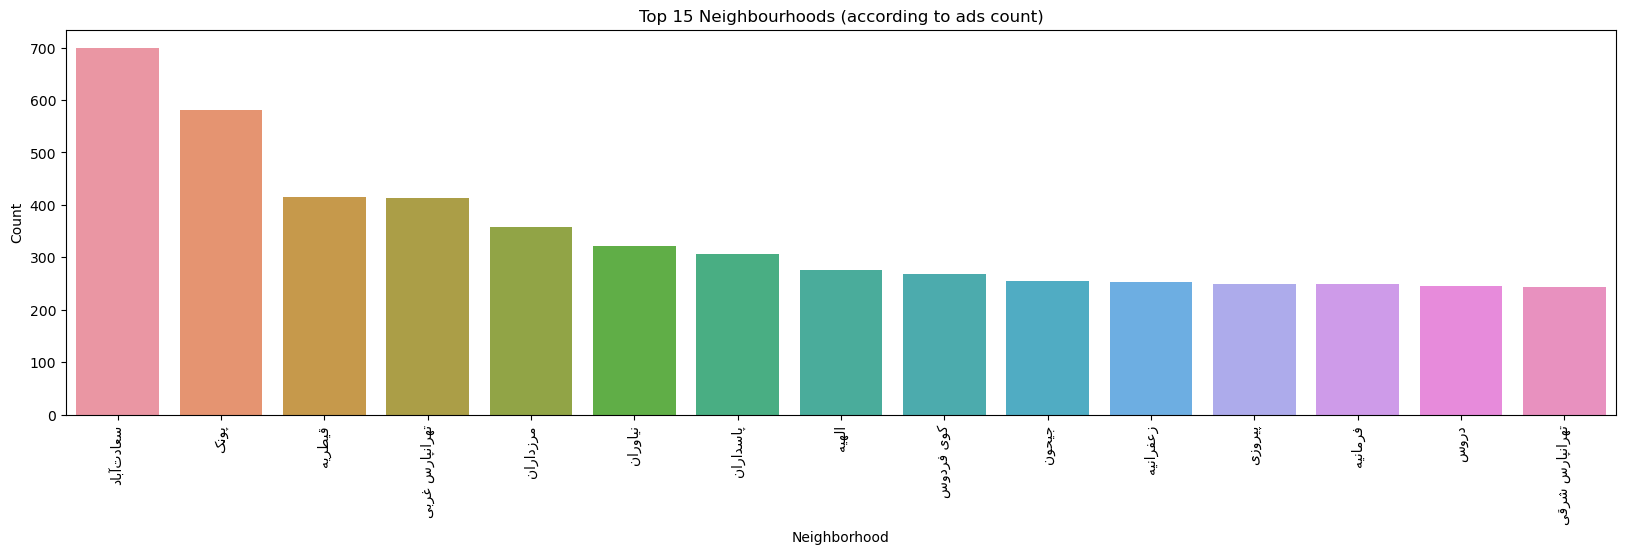

In [311]:
# Show top 15 neighborhoods according to ads count
# create a nw column for reshaping the neighborhood names with their counts
df_head_provinces = df_normal.groupby('neighborhood').size().reset_index(name='count')
df_head_provinces = df_head_provinces[df_head_provinces['count'] > 5].sort_values(by='count', ascending=False)
df_top_15 = df_head_provinces.head(15)
plt.figure(figsize= (20, 5))
# create plot using sns
sns.barplot(data = df_top_15, x = [get_display(reshape(label)) for label in df_top_15.neighborhood], y = 'count')
# plt.xlabel(get_display(reshape('محله ')))
# plt.ylabel(get_display(reshape('تعداد')))
# plt.title(get_display(reshape('15 محله پر آگهی')))

plt.xlabel('Neighborhood');
plt.ylabel('Count');
plt.title('Top 15 Neighbourhoods (according to ads count)');

plt.xticks(rotation = "vertical")
plt.show()

### Average Price in Each Neighborhood
I also calculated the average price of houses in each neighborhood and sorted them in descending order. You can see the top 15 neighborhoods in Tehran.

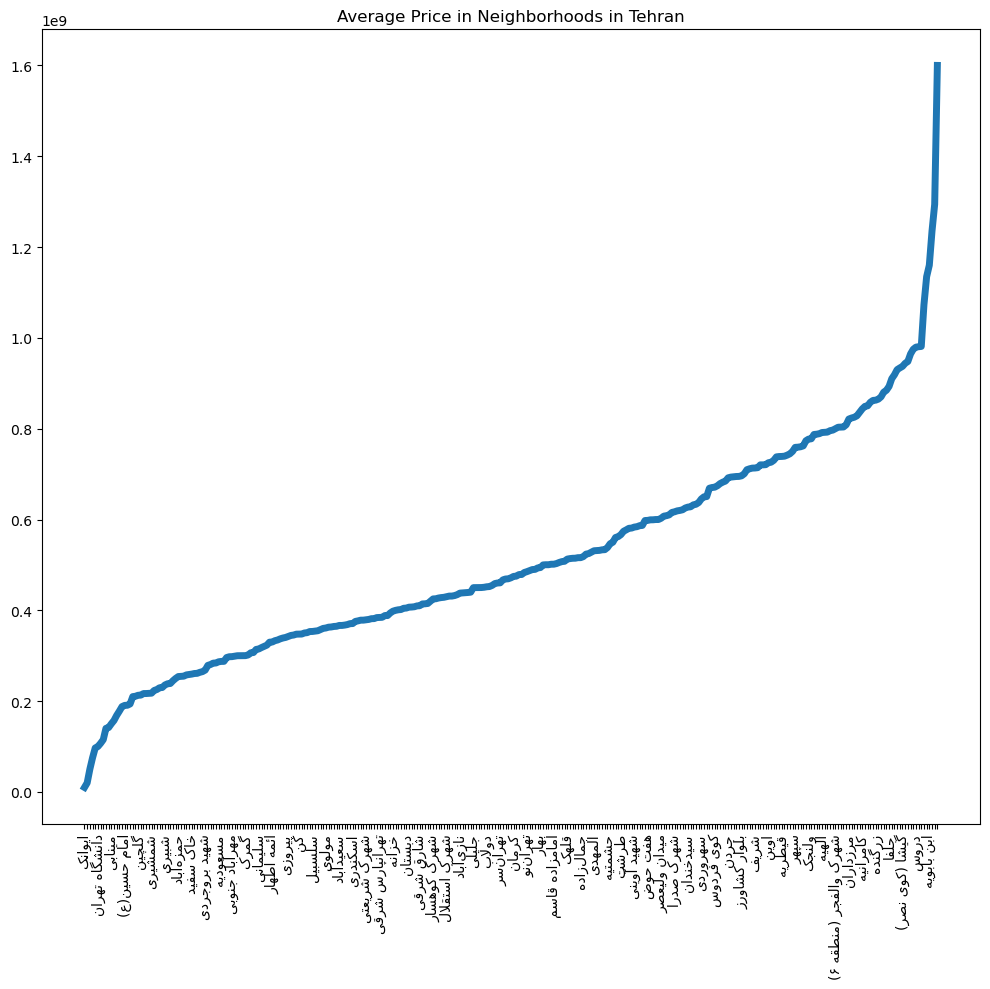

In [312]:
fig , ax = plt.subplots(figsize = (10, 10))
df_temp = df_normal.groupby('neighborhood')[['total_value']].mean().reset_index()
df_temp = df_temp.sort_values('total_value')
g2 = sns.lineplot(data=df_temp, x = [get_display(reshape(label)) for label in df_temp['neighborhood']]
                , y="total_value",linewidth = 5,ax=ax)

for ind, label in enumerate(g2.get_xticklabels()):
    if ind % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
g2.set(title='Average Price in Neighborhoods in Tehran');
g2.set(ylabel='');
# g2.set(xlabel='Neighbourhood')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

## 2.3 Features correlation and distribution
To have a deep view of data, I calculate correlation between features. As you can see in figure, the goal feature (total_value) has the highest correlation to area. To omit the affect of neighbourhood on correlation calculation, I calculate the correlation for records of 1 neighbourhood (سعادت آباد). You can sense the affect of neighbourhood on total_value in the figure too.

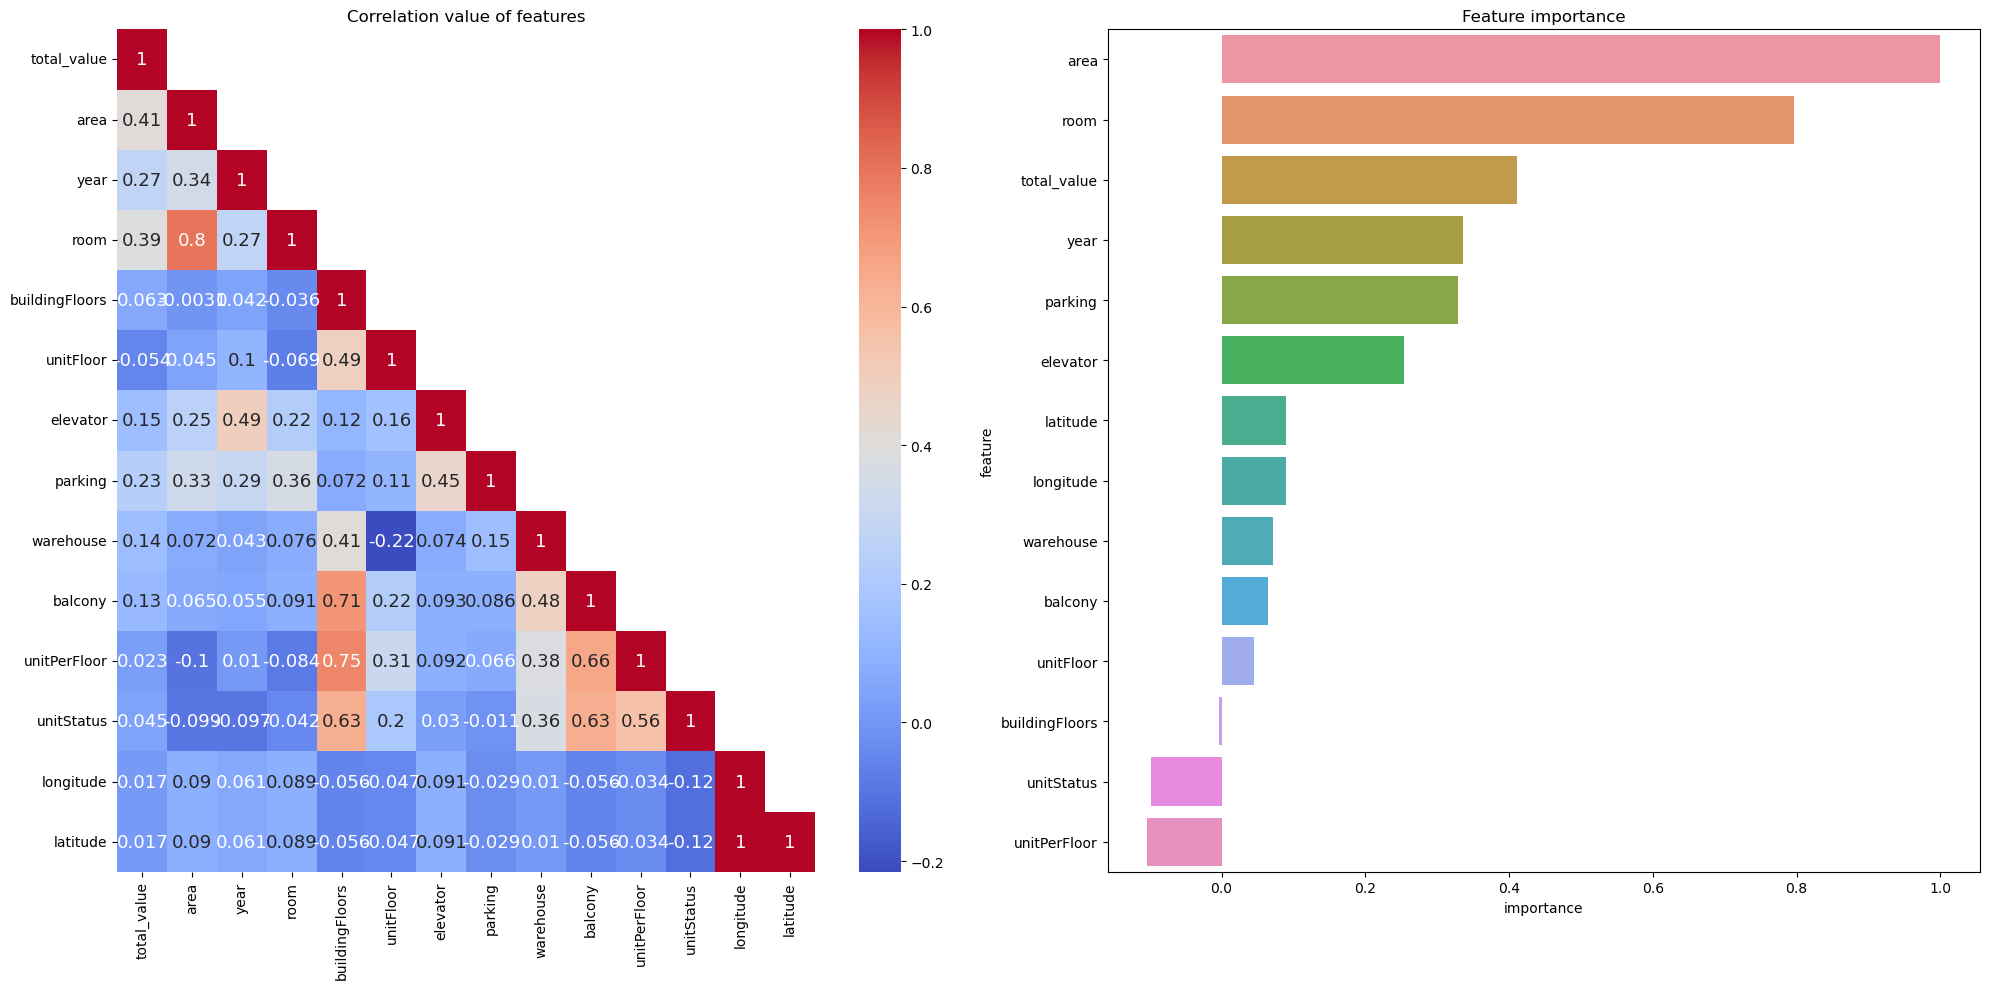

In [313]:
fig , axes = plt.subplots(1,2,figsize = (20, 10))

df_temp = df_normal[(df_normal['neighborhood'].str.contains('سعادت'))]
df_temp = df_temp[['total_value','area','year','room','buildingFloors','unitFloor','elevator','parking','warehouse','balcony','unitPerFloor','unitStatus','longitude', 'latitude']]

df_corr = df_temp.corr()
corr_mask = np.zeros_like(df_corr)
corr_mask[np.triu_indices_from(corr_mask)] = 1
#  main diameter of the correlation matrix = 1
corr_mask[np.diag_indices_from(corr_mask)] = 0


# get columns 'total_value','area','year','room','buildingFloors','unitFloor','elevator','parking','warehouse','balcony','unitPerFloor','unitStatus','longitude', 'latitude'
g1 = sns.heatmap(df_corr,annot=True, annot_kws={"size": 13}, ax=axes[0], mask=corr_mask, cmap='coolwarm')
g1.set(title='Correlation value of features');
# calculate feaure importance using cor and store them in a dataframe
df_temp_importance = pd.DataFrame(df_corr.iloc[1,:].sort_values(ascending=False)).reset_index()
df_temp_importance.columns = ['feature', 'importance']
# create plot for feature importance x axis is the feature name and y axis is the importance value
g2 = sns.barplot(x = 'importance', y = 'feature', data = df_temp_importance, ax=axes[1])
g2.set(title='Feature importance');

plt.tight_layout()
plt.show()

## 2.4 Data Distribution Histogram
I also plotted the histogram of each feature to see the distribution of data. As you can see, the data is not normally distributed and it is skewed. I will use log transformation to make the data normally distributed.

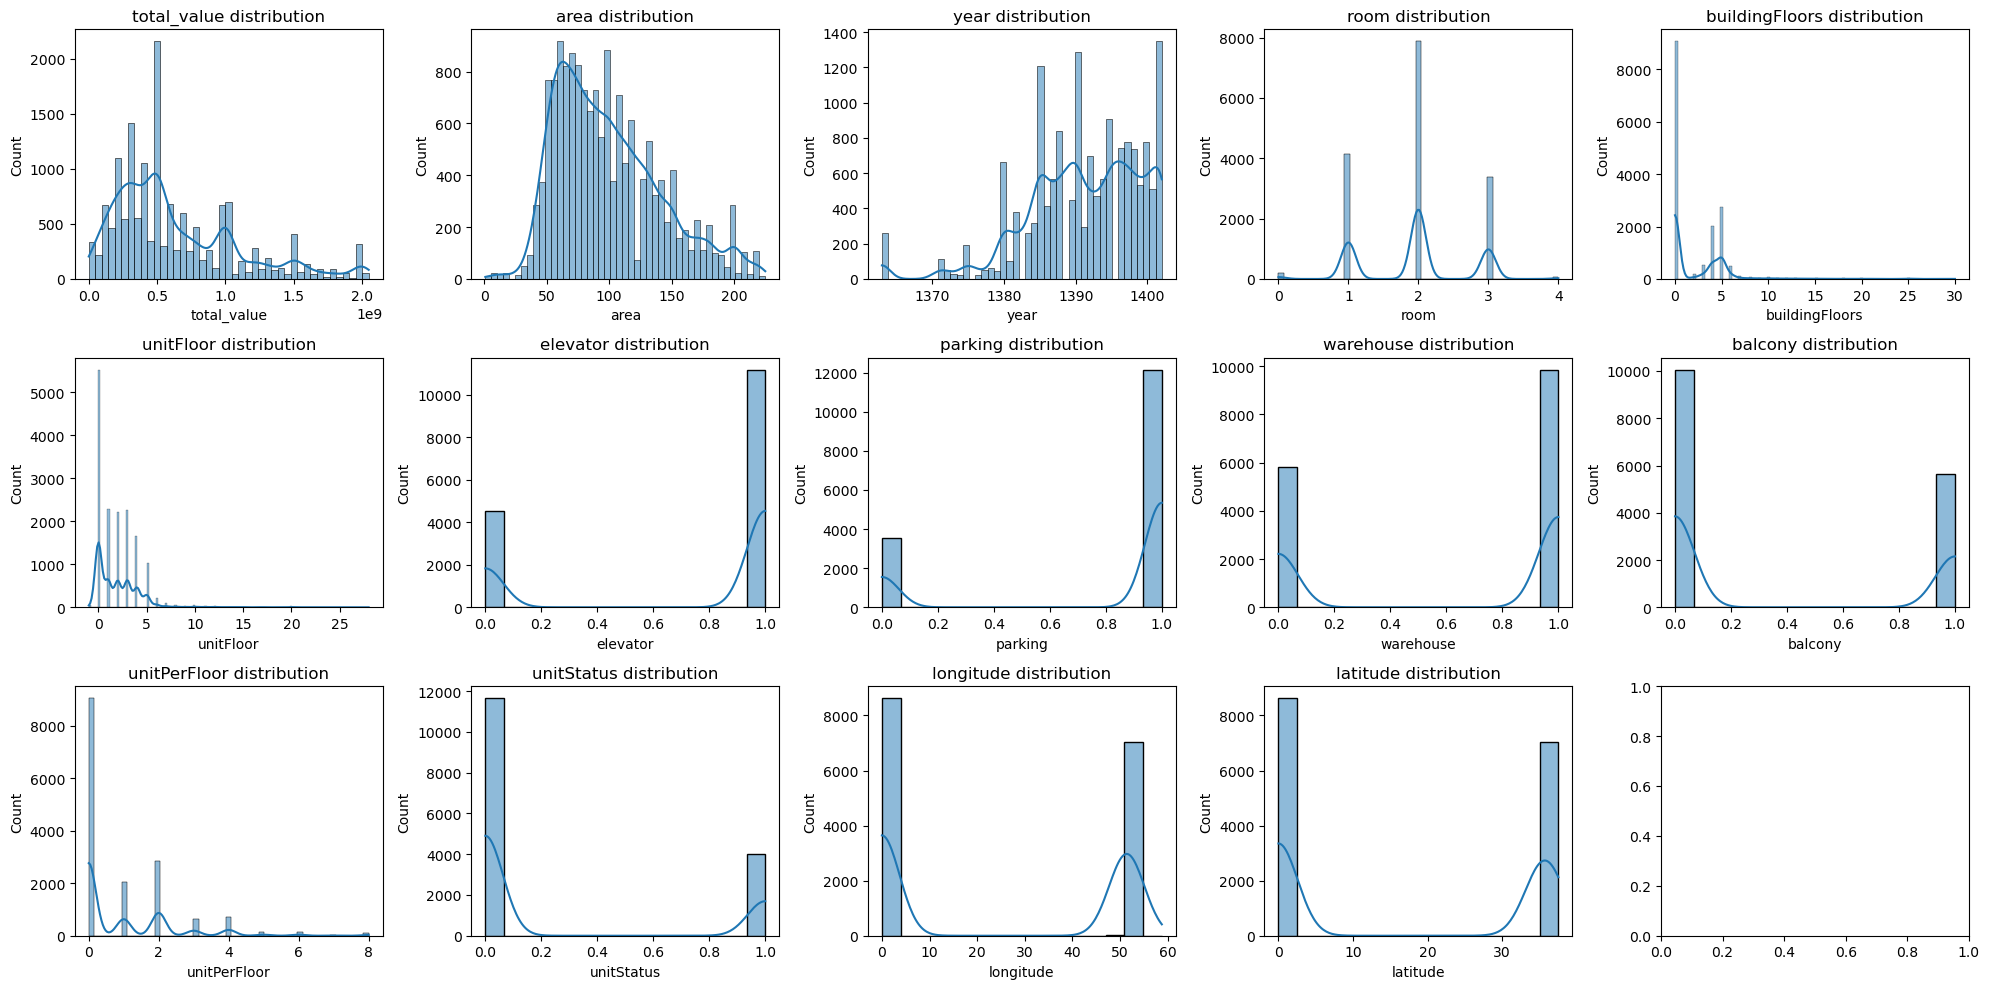

In [316]:
# statistical distribution map of all features
fig , axes = plt.subplots(3,5,figsize = (20, 10))
# create a list of features
features = ['total_value','area','year','room','buildingFloors','unitFloor','elevator','parking','warehouse','balcony','unitPerFloor','unitStatus','longitude', 'latitude']
# create a loop for each feature
for i, feature in enumerate(features):
    # create a scatter plot for each feature
    g = sns.histplot(df_normal[feature], kde=True,ax=axes[i//5, i%5])
    g.set(title=f'{feature} distribution')
plt.tight_layout()
plt.show()

### Visualize Data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


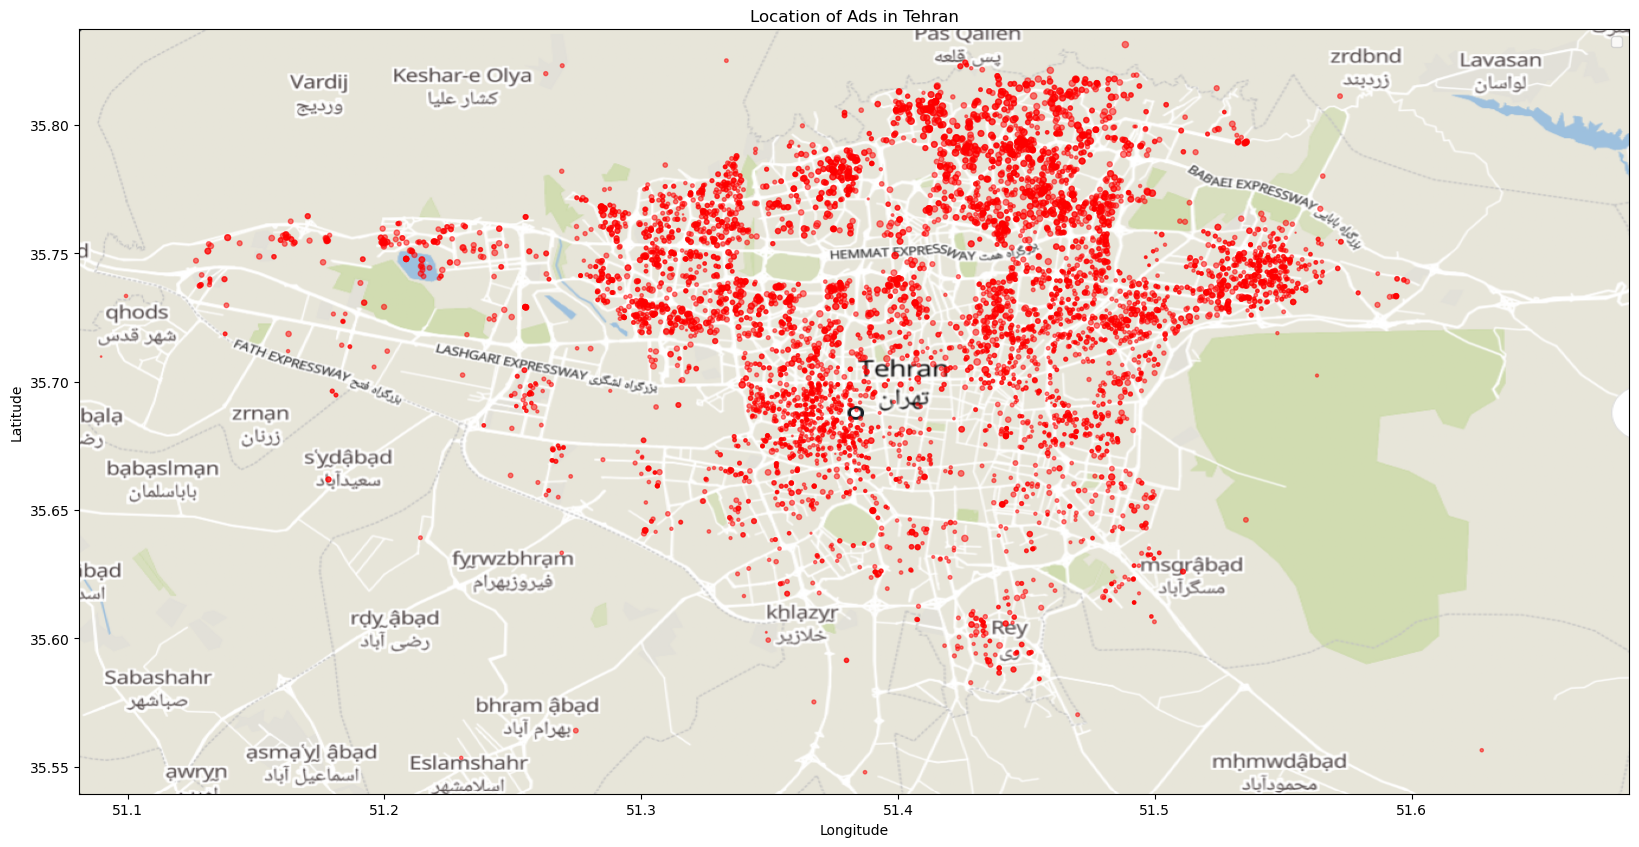

In [317]:
# Create plot using Tehran.shp as background and visualize location of ads on plot using their latitude and longitude

# Load Tehran shapefile
tehran = gpd.read_file('./Tehran_Map/POLYGON.shp', encoding='utf-8')

# Create plot
fig, ax = plt.subplots(figsize=(20, 20))
ax.plot(ax=ax, color='lightgrey')
ax.set_title('Location of Ads in Tehran')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# change background of plot to tehran_back.png
ax.imshow(plt.imread('./Tehran_Map/tehran_back.png'), extent=[51.081164, 51.684722, 35.539503, 35.837116])
#limit the map to Tehran
ax.set_xlim(51.081164, 51.684722)
ax.set_ylim(35.539503, 35.837116)

# Plot ads and density as area
ax.scatter(df_normal['longitude'], df_normal['latitude'], s=(df_normal['area']*0.1), alpha=0.5, color='red')
plt.legend()
plt.show()

### Price Map of Tehran

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


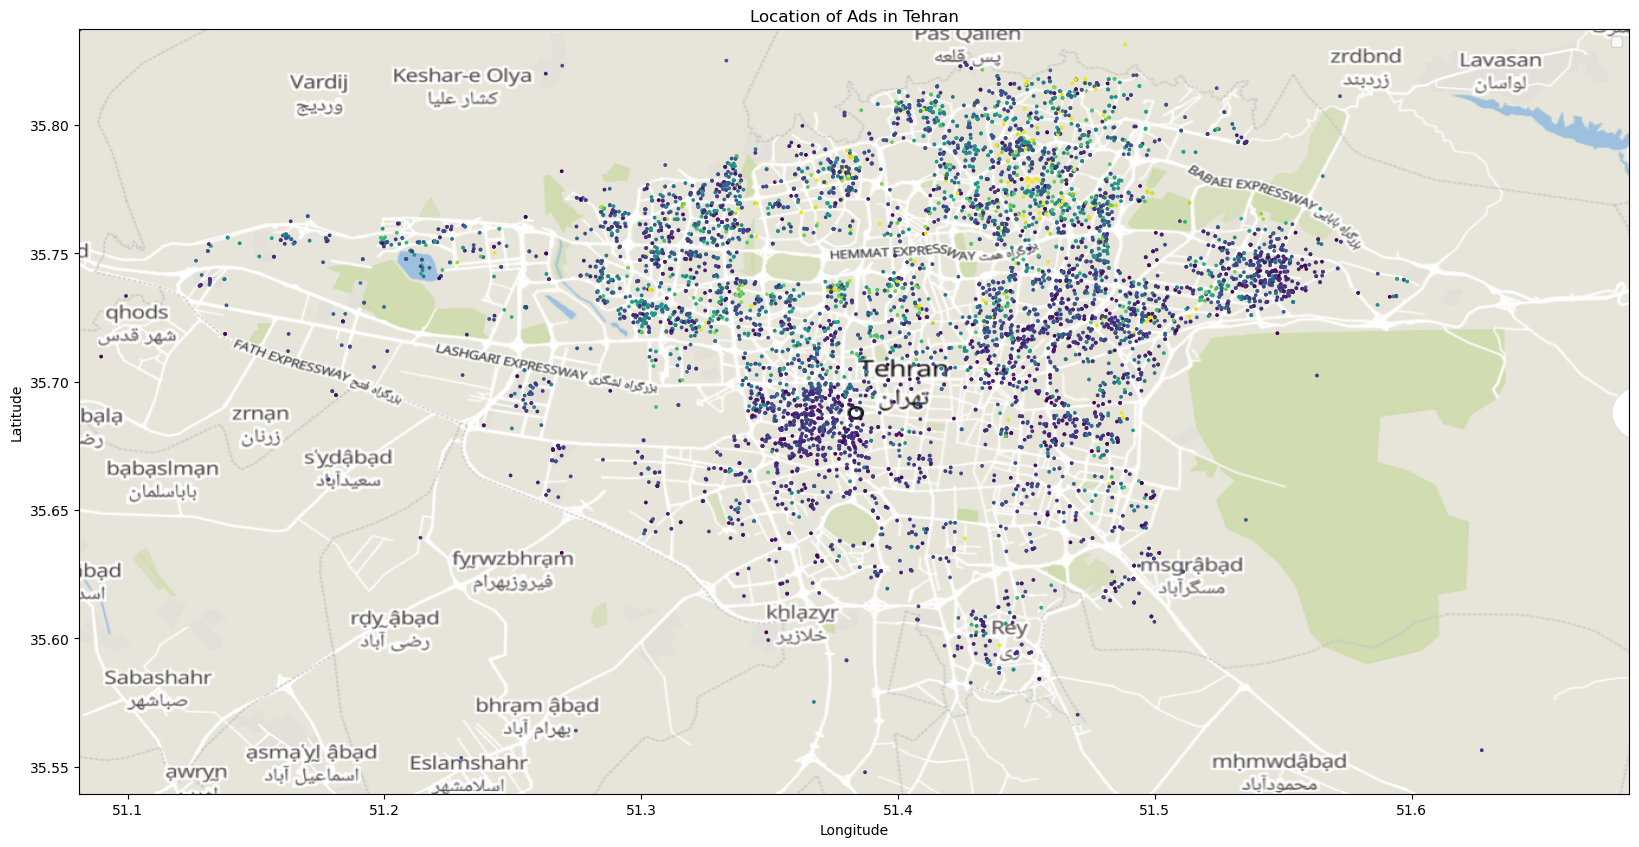

In [319]:
# Create plot using Tehran.shp as background and visualize location of ads on plot using their latitude and longitude

# Load Tehran shapefile
tehran = gpd.read_file('./Tehran_Map/POLYGON.shp', encoding='utf-8')

# Create plot
fig2, ax2 = plt.subplots(figsize=(20, 20))
ax2.plot(ax=ax, color='lightgrey')
ax2.set_title('Location of Ads in Tehran')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
# change background of plot to tehran_back.png
ax2.imshow(plt.imread('./Tehran_Map/tehran_back.png'), extent=[51.081164, 51.684722, 35.539503, 35.837116])
#limit the map to Tehran
ax2.set_xlim(51.081164, 51.684722)
ax2.set_ylim(35.539503, 35.837116)

# Plot ads and density as area
# show total_value of each ad as color
sc = ax2.scatter(df_normal['longitude'], df_normal['latitude'], s=3, alpha=1, c=df_normal['total_value'], cmap='viridis')
# add color bar of size of 20 px
# cbar = ax2.colorbar(sc, ax=ax2, orientation='vertical', pad=0.001)
plt.legend()
plt.show()

### Final valid data
At the end of data purification, dataset will consist of 2203 records. You can see distribution of data in top 15 neighbourhoods (according to sample counts), in the following graph.

In [273]:
df_normal.shape

(15684, 15)

In [320]:
df_normal

neighborhood  area  year  room  buildingFloors  unitFloor  elevator  \
3               دروس    58  1394     1               5          0         1   
4               دروس   165  1393     3               0          0         1   
6               دروس   190  1401     3               5          5         1   
8               دروس   180  1387     3               5          1         1   
9               دروس   130  1385     2               5          4         1   
...              ...   ...   ...   ...             ...        ...       ...   
17932       مرادآباد   106  1380     2               8          1         1   
17933       مرادآباد   106  1380     2               0          1         1   
17934          بازار    55  1380     1               0          0         0   
17935           زمزم    65  1390     1               0          0         1   
17936  شهرک فرهنگیان   114  1363     2               0          0         0   

       parking  warehouse  balcony  unitPerFloor  unitStatus  longitude  \
3            1          1        0             4           1   0.000000   
4            1          1        0             0           0   0.000000   
6            1          1        1             1           0   0.000000   
8            1          1        1             2           0  51.456573   
9            1          1        1             2           0   0.000000   
...        ...        ...      ...           ...         ...        ...   
17932        1          1        1             4           0  51.329960   
17933        1          0        0             0           0  51.329960   
17934        0          1        0             0           0   0.000000   
17935        0          1        0             0           0   0.000000   
17936        0          0        0             0           0  51.280326   

        latitude   total_value  
3       0.000000  7.003600e+08  
4       0.000000  8.018000e+08  
6       0.000000  1.203540e+09  
8      35.778490  5.015000e+08  
9       0.000000  1.800000e+06  
...          ...           ...  
17932  35.780730  5.004500e+08  
17933  35.780730  5.004500e+08  
17934   0.000000  3.000450e+08  
17935   0.000000  3.800030e+08  
17936  35.712824  7.500000e+08  

[15684 rows x 15 columns]

# Model Evaluation, Tuning and Prediction

In [325]:
import multiprocessing
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

!pip install xgboost
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor

!pip install lightgbm
from lightgbm import LGBMRegressor

### Generate Input Array and Output Vector
In order to build my model, I need to get dummies of neighborhood and change the type of data set to numpy array.

The input array will have 5276 records and 96 features and the output vector will have 5276 elements at the end.

In [356]:
df_main = df_normal.copy()

df_main = pd.get_dummies(df_main, columns=["neighborhood"])

temp_data = df_main.to_numpy()

X = temp_data[:,1:]
y = temp_data[:,0]

In [357]:
df_main.head(15)

area  year  room  buildingFloors  unitFloor  elevator  parking  warehouse  \
3     58  1394     1               5          0         1        1          1   
4    165  1393     3               0          0         1        1          1   
6    190  1401     3               5          5         1        1          1   
8    180  1387     3               5          1         1        1          1   
9    130  1385     2               5          4         1        1          1   
10   220  1397     3               5          2         1        1          1   
11   180  1398     3               5          5         1        1          1   
14   190  1400     3               0          0         1        1          1   
17   160  1396     3               0          0         1        1          1   
21   140  1398     3               0          0         1        1          1   
22    40  1402     1               0          0         1        0          1   
24   180  1392     3               4          1         1        1          1   
27   190  1386     3               0          0         1        1          1   
28   145  1398     3               5          1         1        1          1   
29   120  1388     2               5          3         1        1          1   

    balcony  unitPerFloor  ...  neighborhood_کوی هفدهم شهریور  \
3         0             4  ...                          False   
4         0             0  ...                          False   
6         1             1  ...                          False   
8         1             2  ...                          False   
9         1             2  ...                          False   
10        1             1  ...                          False   
11        1             2  ...                          False   
14        0             0  ...                          False   
17        0             0  ...                          False   
21        1             0  ...                          False   
22        0             0  ...                          False   
24        1             2  ...                          False   
27        0             0  ...                          False   
28        1             2  ...                          False   
29        1             2  ...                          False   

    neighborhood_گاندی  neighborhood_گرگان  neighborhood_گلاب دره  \
3                False               False                  False   
4                False               False                  False   
6                False               False                  False   
8                False               False                  False   
9                False               False                  False   
10               False               False                  False   
11               False               False                  False   
14               False               False                  False   
17               False               False                  False   
21               False               False                  False   
22               False               False                  False   
24               False               False                  False   
27               False               False                  False   
28               False               False                  False   
29               False               False                  False   

    neighborhood_گلچین  neighborhood_گمرک  neighborhood_گیشا (کوی نصر)  \
3                False              False                        False   
4                False              False                        False   
6                False              False                        False   
8                False              False                        False   
9                False              False                        False   
10               False              False                        False   
11               False              False  

### Comparing Different Algorithms of Regression
At first, I prepare train and test sets for inputs and outputs. I use cross validation to ensure that the score and error values are more accurate.

I compare different algorithms of regression to pick the best one as my model. For this purpose, I declare some lists and fuctions to calculate and show the performance of each regression algorithm.

In [358]:
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [359]:
n_cores = multiprocessing.cpu_count() # Getting the number of cores for multiprocessing
Model = []
RMSE = []
MAE = []
MSE = []
R_Square = []
adj_rsquared = []
CV = []
Score = []

names = ["ExtraTrees Regressor", "Gradient Boosting Regressor", "Random Forest Regressor",  
         "Bagging Regressor","XGB Regressor","Linear Regression", "Ridge Regression", 
         "Lasso Regression", "Decision Tree Regressor", "XGBRF Regressor", "Adaboost Regressor", 
         "LGBM Regressor","SVR"]
models = [ExtraTreesRegressor(), GradientBoostingRegressor(), RandomForestRegressor(),  
          BaggingRegressor(), XGBRegressor(), LinearRegression(), Ridge(), 
          Lasso(), DecisionTreeRegressor(), XGBRFRegressor(), AdaBoostRegressor(), LGBMRegressor(), SVR()]

names_to_plot = ["XGBRF Regressor", "Random Forest Regressor", "Bagging Regressor", "ExtraTrees Regressor", "Gradient Boosting Regressor", "LGBM Regressor"]
# models_to_plot = [XGBRFRegressor(),  RandomForestRegressor()]

In [360]:
def evaluate(true, predicted, variable_of_model):
    MAE.append(metrics.mean_absolute_error(true, predicted))
    MSE.append(metrics.mean_squared_error(true, predicted))
    RMSE.append(np.sqrt(metrics.mean_squared_error(true, predicted)))
    R_Square.append(metrics.r2_score(true, predicted))
    n= X_test.shape[0]
    p= X_test.shape[1] - 1
    adj_rsquared.append(1 - (1 - R_Square[-1]) * ((n - 1)/(n-p-1)))
    cv_accuracies = cross_val_score(estimator = variable_of_model, X = X_train, y = y_train.ravel(), cv = 5,verbose = 1)
    CV.append(cv_accuracies.mean())
    Score.append(variable_of_model.score(X_test, y_test.ravel()))

def pred_vis(name, y_test_vis, y_pred_vis):
    if y_test_vis.shape[0] > 300:
        y_test_vis = y_test_vis[:300]
        y_pred_vis = y_pred_vis[:300]
        
    y_test_m_vis = y_test_vis
    plt.figure(figsize=(18,5))
    plt.title("{} Prediction" .format(name))
    plt.plot(y_test_m_vis, c="steelblue", alpha=1)
    plt.plot(y_pred_vis, c="darkorange", alpha=.7,linestyle='dashed')
    legend_list = ["y_test", "y_pred"]
#     plt.xlabel("Var")
    plt.ylabel("Output")
    plt.legend(legend_list, loc=1,fontsize="10")
    plt.grid(True)
    plt.show()

# regression visualization
def reg_vis(name, y_test_vis, y_pred_vis):
    # Show the results of a linear regression within each dataset
    plt.figure(figsize=(18,5))
    sns.regplot(x=y_test_vis, y=y_pred_vis, line_kws={"color": "red"})
    plt.title("{} Regression" .format(name))
    plt.xlabel("y_test")
    plt.ylabel("y_pred")
    plt.show()


def fit_and_predict(name, model):
    # switch case model
    match name:
        case "SVR":
            variable_of_model = SVR(gamma = 0.05)
        case "Lasso Regression":
            variable_of_model = Lasso(alpha = 0.5)
        case "Ridge Regression":
            variable_of_model = Ridge(alpha = 7)
        case "Random Forest Regressor":
            variable_of_model = RandomForestRegressor(
                n_estimators=51, min_samples_leaf=5, min_samples_split=3, random_state=42,
                n_jobs=int(1*n_cores))
        case "Bagging Regressor":
            variable_of_model = BaggingRegressor(n_estimators=51, random_state=42, n_jobs=int(1*n_cores))
        case "ExtraTrees Regressor":
            variable_of_model = ExtraTreesRegressor(n_estimators=71, random_state=42, n_jobs=int(0.8*n_cores))
        case "Gradient Boosting Regressor":
            variable_of_model = GradientBoostingRegressor(n_estimators=101, random_state=42)
        case _:
            variable_of_model = model
    variable_of_model.fit(X_train, y_train)
    pred = variable_of_model.predict(X_test)
    evaluate(y_test, pred, variable_of_model)
    if name in names_to_plot :
        pred_vis(name, y_test, pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.9s finished


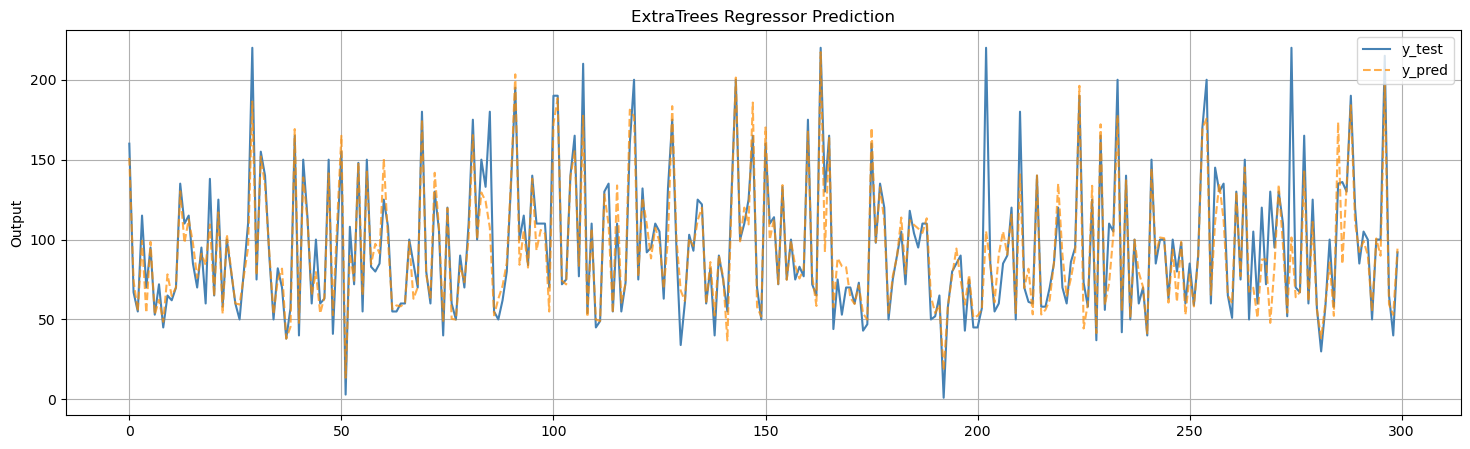

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [361]:
for name, model in zip(names, models):
    fit_and_predict(name, model)

### Result
After applying fit and predict to all regression algorithms, I can get a good result of each algorithm.

Since, it is a regression task, I should pay attention to the Score and error values like MSE simultaneously.

In [ ]:
evaluation_dataframe = pd.DataFrame({"Model": names,
                                     "MAE": MAE,
                                     "MSE": MSE,
                                     "RMSE": RMSE,
                                     "R Squared": R_Square,
                                     "adj R Squared": adj_rsquared,
                                     "Cross Validation": CV,
                                     "Score" : Score})

In [ ]:
evaluation_dataframe.sort_values("Score")

Model        MAE          MSE       RMSE  R Squared  \
12                          SVR  32.910960  1821.650888  42.680802  -0.028460   
10           Adaboost Regressor  20.983956   637.919792  25.257074   0.639846   
7              Lasso Regression  16.912348   492.957565  22.202648   0.721688   
5             Linear Regression  14.898094   384.613501  19.611566   0.782857   
6              Ridge Regression  14.874440   383.289968  19.577793   0.783604   
9               XGBRF Regressor  14.035222   345.298552  18.582211   0.805053   
8       Decision Tree Regressor  10.772792   325.714257  18.047555   0.816110   
1   Gradient Boosting Regressor  13.539582   323.778103  17.993835   0.817203   
11               LGBM Regressor  11.961196   261.671769  16.176272   0.852266   
0          ExtraTrees Regressor  10.515571   261.009382  16.155785   0.852640   
4                 XGB Regressor  11.774931   257.041638  16.032518   0.854881   
2       Random Forest Regressor  11.171178   241.285289  15.533361   0.863776   
3             Bagging Regressor   9.889432   206.581047  14.372928   0.883369   

    adj R Squared  Cross Validation     Score  
12      -0.085751         -0.033280 -0.028460  
10       0.619783          0.650628  0.639846  
7        0.706185          0.718053  0.721688  
5        0.770761          0.775163  0.782857  
6        0.771549          0.777010  0.783604  
9        0.794193          0.797425  0.805053  
8        0.805866          0.790441  0.816110  
1        0.807020          0.810731  0.817203  
11       0.844037          0.842970  0.852266  
0        0.844432          0.840105  0.852640  
4        0.846797          0.847040  0.854881  
2        0.856188          0.852973  0.863776  
3        0.876872          0.869374  0.883369